Imports:

In [3]:
import os
import time
import json

import numpy as np
import pandas as pd
import torch

from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

import faiss

from sentence_transformers import SentenceTransformer, util

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Max\Desktop\TREC2025\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create dataFrame for the question assessment

In [26]:
# Specify the path to the text file
file_path = '2024-question-assessment.txt'

array = []

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.split("\t")
        if (line[5] == "4" or line[5] == "3" or line[5] == "1"):
            array.append(line)
            
dataFrame = pd.DataFrame(array)
dataFrame.columns = ["AID", "Article", "RID", "Model", "Order", "Assessment", "Useless", "Question"]
dataFrame.drop(columns=["AID", "Model", "RID", "Useless", "Order"], inplace=True)

dataFrame.head()

,Article,Assessment,Question
0,clueweb22-en0030-87-05450,1,"Who is Helen Russell, the author of the articl..."
1,clueweb22-en0030-87-05450,1,Has the show John Dillermand received support ...
2,clueweb22-en0030-87-05450,1,What is the professional credentials of Christ...
3,clueweb22-en0030-87-05450,1,"Who is Erla Heinesen Højsted, cited in the art..."
4,clueweb22-en0030-87-05450,1,Does The Guardian clearly described how the sh...


Prompt for labeling our data into categories, outputs as an csv file named output.csv

In [27]:
load_dotenv()

# Initialize client properly
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
qArray = [row[7] for row in array]  # Adjust if needed

def format_prompt(qs):
    categories = [
        "Author Bias",
        "Factual Query",
        "Author Reputation",
        "Publication Reputation",
        "Bad Question"
    ]
    prompt = (
    f"Classify each of the following questions into one of these categories per line: {', '.join(categories)}.\n\n"
    "These are the criteria for a good question:\n"
    "- Questions must be self-contained and explain the full context.\n"
    "- Each question must be at most 120 characters long.\n"
    "- Questions should be reasonably answerable by a single web page.\n"
    "- Avoid compound questions; focus on a single topic per question.\n"
    '\nReturn the result as plain CSV with no extra text. Each row should have two columns: '
    '"Question" and "Category". Format like this:\n\n'
    '"Question","Category"\n'
    '"Example question here?","Author Bias"\n'
)


    for i, q in enumerate(qs, 1):
        prompt += f"{i}. {q.strip()}\n"
    return prompt

# Batch the questions to avoid exceeding token/context limits
batch_size = 300  # Adjust as needed for your model/context
prompts = [format_prompt(qArray[i:i+batch_size]) for i in range(0, len(qArray), batch_size)]
outputs = []

for prompt_text in tqdm(prompts, desc="Processing batches"):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt_text}],
        temperature=0
    )
    outputs.append(response.choices[0].message.content)
    time.sleep(0.2)
# Save all outputs to a single CSV file
with open("output1.csv", "w", encoding="utf-8") as f:
    header_written = False
    for output in outputs:
        lines = output.strip().splitlines()
        if not header_written:
            f.write(lines[0] + "\n")  # Write header
            header_written = True
        for line in lines[1:]:
            f.write(line + "\n")

Processing batches:   0%|          | 0/19 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 19/19 [21:58<00:00, 69.38s/it]


Load all data into train_test_split and add it to a BERT readable dataset

In [4]:
df1 = pd.read_csv("output.csv", header=None, names=["Question", "Category"])

col1 = df1.iloc[:, 0].to_numpy()
col2 = df1.iloc[:, 1].to_numpy()

Q_train, Q_test, c_train, c_test = train_test_split(col1, col2, test_size=0.3, random_state=42)

# Define label names for readability (optional)
label_names = ["Author Bias",
        "Factual Query",
        "Author Reputation",
        "Publication Reputation"]

# Load tokenizer and model with built-in classification head
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_names))


le = LabelEncoder()
# Define custom Dataset class
class TextDataset(Dataset):
    def __init__(self, Q_train, c_train):
        self.encodings = tokenizer(Q_train, truncation=True, padding=True, return_tensors="pt")
        c_train_encoded = le.fit_transform(c_train) 
        self.labels = torch.tensor(c_train_encoded)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Prepare dataset
dataset = TextDataset(list(Q_train), list(c_train))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defines hyperparameters for the model and trains it.

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    num_train_epochs=3,
    auto_find_batch_size = True,
    save_strategy="no"
)

# Set up Trainer API to handle training loop
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("fine_tuned_model")

Train BERT using KFOLD validation

In [ ]:
df1 = pd.read_csv("output.csv", header=None, names=["Question", "Category"])
col1 = df1.iloc[:, 0].to_numpy()
col2 = df1.iloc[:, 1].to_numpy()
le = LabelEncoder()
# Define custom Dataset class
class TextDataset(Dataset):
    def _init_(self, col1, col2):
        self.encodings = tokenizer(col1, truncation=True, padding=True, return_tensors="pt")
        col2_encoded = le.fit_transform(col2)
        self.labels = torch.tensor(col2_encoded)
    def _len_(self):
        return len(self.labels)
    def _getitem_(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item
# Prepare dataset
dataset = TextDataset(list(col1), list(col2))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
for fold, (train_indices, val_indices) in enumerate(skf.split(col1, col2)):
    print(f"Training Fold {fold+1}/{5}")
    # Split dataset into train and validation sets for the current fold
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    # Training loop
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = torch.nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    for epoch in range(3):  # Adjust the number of epochs as needed
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    # Evaluation loop
    model.eval()
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted_labels = torch.max(outputs.logits, dim=1)
            val_predictions.extend(predicted_labels.tolist())
            val_labels.extend(labels.tolist())
    fold_accuracy = accuracy_score(val_labels, val_predictions)
    fold_accuracies.append(fold_accuracy)
    print(f"Accuracy for Fold {fold+1}: {fold_accuracy}")
# Calculate average accuracy across all folds
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"Average Accuracy: {average_accuracy}")

Load trained model from disk

In [7]:
model = BertForSequenceClassification.from_pretrained("./fine_tuned_model")

Use the model to make predictions on the test data

In [8]:
import random
#Q_test_list = Q_test.astype(str).tolist()
batch_size = 64  # Tune this based on your RAM

predictions = []

test_data = [
    # Author Bias
    "Does the article favor Ukraine's perspective in its reporting on the drone strike?",
    "Are Russian sources or officials quoted to balance the Ukrainian claims in the article?",
    "Is emotionally charged language used to describe Ukraine’s attack on Russian bombers?",
    "Does the article present Russia’s version of events with equal weight as Ukraine’s?",
    "Is there any indication of selective omission in describing the drone strike outcome?",
    # Author Reputation
    "Has the author of the article reported on Ukraine-Russia issues before?",
    "What is the past accuracy record of the journalist who wrote the drone strike piece?",
    "Has the author been accused of bias or misinformation in past reporting?",
    "Is the author a staff reporter or a freelance contributor for Reuters?",
    "Does the journalist have expertise in military or geopolitical reporting?",
    # Factual Query
    "How many Russian aircraft were destroyed in Ukraine’s June 1 drone strike?",
    "Which air bases were targeted during Ukraine’s June 1 drone operation?",
    "What kind of drones did Ukraine use in the June 1 air base attack?",
    "How was satellite imagery used to assess the damage to Russian bombers?",
    "What was the official Russian response to the June 1 drone attack?",
    # Publication Reputation
    "What is Reuters' track record for accuracy in military conflict reporting?",
    "Is Reuters considered a neutral source in coverage of the Ukraine-Russia war?",
    "Has Reuters been criticized for bias in its reporting on Eastern Europe?",
    "What are Reuters’ editorial standards for verifying wartime events?",
    "How does Reuters handle corrections when reporting errors are discovered?"
]

test_data_c = ["Author Bias", "Author Bias", "Author Bias", "Author Bias", "Author Bias",
               "Author Reputation", "Author Reputation", "Author Reputation", "Author Reputation", "Author Reputation",
               "Factual Query", "Factual Query", "Factual Query", "Factual Query", "Factual Query",
               "Publication Reputation", "Publication Reputation", "Publication Reputation", "Publication Reputation", "Publication Reputation"]



# Wrap the range with tqdm for a progress bar
for i in tqdm(range(0, len(test_data), batch_size), desc="Running inference"):
    batch = test_data[i:i+batch_size]
    test_encodings = tokenizer(batch, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**test_encodings)
        batch_preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(batch_preds)

# Convert predicted tensor to list of integers
predicted_labels = [label.item() for label in predictions]

predicted_labels = le.inverse_transform(predicted_labels)

# Print results
for i in range(len(test_data)):
    print(test_data[i] + "----->" + predicted_labels[i])

Running inference: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Does the article favor Ukraine's perspective in its reporting on the drone strike?----->Author Bias
Are Russian sources or officials quoted to balance the Ukrainian claims in the article?----->Bad Question
Is emotionally charged language used to describe Ukraine’s attack on Russian bombers?----->Bad Question
Does the article present Russia’s version of events with equal weight as Ukraine’s?----->Author Bias
Is there any indication of selective omission in describing the drone strike outcome?----->Author Bias
Has the author of the article reported on Ukraine-Russia issues before?----->Author Reputation
What is the past accuracy record of the journalist who wrote the drone strike piece?----->Author Reputation
Has the author been accused of bias or misinformation in past reporting?----->Author Bias
Is the author a staff reporter or a freelance contributor for Reuters?----->Author Reputation
Does the journalist have expertise in military or geopolitical reporting?----->Author Reputation
Ho

Prints out a classifcation report for the test data output

Accuracy: 0.35

Classification Report:
                        precision    recall  f1-score   support

           Author Bias       0.75      0.60      0.67         5
     Author Reputation       1.00      0.80      0.89         5
          Bad Question       0.00      0.00      0.00         0
         Factual Query       0.00      0.00      0.00         5
Publication Reputation       0.00      0.00      0.00         5

              accuracy                           0.35        20
             macro avg       0.35      0.28      0.31        20
          weighted avg       0.44      0.35      0.39        20



c:\Users\Max\Desktop\TREC2025\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Max\Desktop\TREC2025\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Max\Desktop\TREC2025\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Max\De

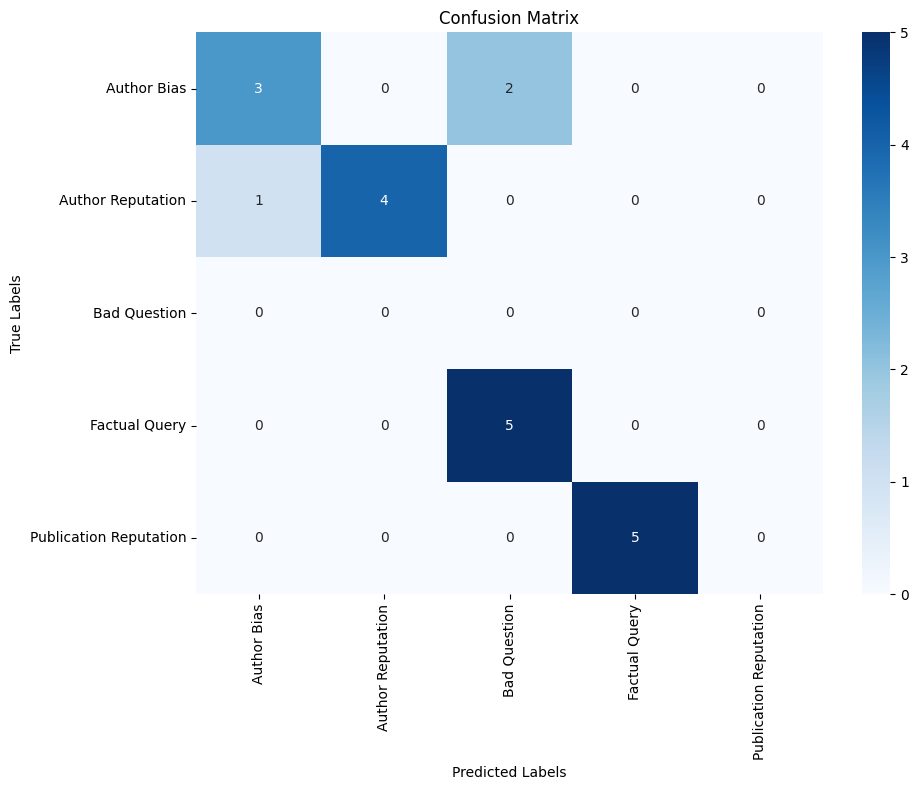

In [9]:
# Convert predicted tensor to list of integers
predicted_labels = [label.item() for label in predictions]

predicted_labels = le.inverse_transform(predicted_labels)
# Accuracy
print("Accuracy:", accuracy_score(test_data_c, predicted_labels))

# Classification report
print("\nClassification Report:")
print(classification_report(test_data_c, predicted_labels))

# Confusion matrix
cm = confusion_matrix(test_data_c, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


Creates a Pandas dataFrame from the clueweb database

In [ ]:
# Specify the path to the text file
file_path = 'trec-2024-lateral-reading-task2-baseline-documents.jsonl'


with open(file_path, 'r', encoding="utf8") as f:
    data = [json.loads(line) for line in f]

clue_df = pd.DataFrame(data)

print(len(clue_df))
clue_df.drop(columns=["URL-hash", "Language"], inplace=True)
clue_df.head()

38131


,URL,ClueWeb22-ID,Clean-Text
0,https://www.dailymail.co.uk/news/article-10130...,clueweb22-en0032-91-05114,"Japan's Princess Mako marries commoner, loses ..."
1,https://www.nytimes.com/2021/08/26/opinion/afg...,clueweb22-en0027-70-17775,Opinion | Let’s Not Pretend That the Way We Wi...
2,https://www.politicshome.com/thehouse/article/...,clueweb22-en0032-18-01494,No longer can China’s atrocities against the U...
3,https://medicaladvise.org/clinical-trials-rese...,clueweb22-en0012-53-13803,How does molnupiravir work? - Medical Advise\n...
4,https://www.euronews.com/2021/12/10/mexico-tru...,clueweb22-en0002-69-11564,Mexico truck crash: Dozens killed after lorry ...


In [6]:
def print_first_lines(filepath, num_lines=10):
    with open(filepath, 'r', encoding='utf-8') as f:
        for _ in range(num_lines):
            line = f.readline()
            if not line:
                break
            print(line.rstrip())

# Usage example
print_first_lines('msmarco_v2.1_doc_00.json', 5)
print("----------------")
print_first_lines('msmarco_v2.1_doc_segmented_00.json', 10)

{"url": "http://0-60.reviews/0-60-times/", "title": "0-60 Times - 0-60 | 0 to 60 Times & 1/4 Mile Times | Zero to 60 Car Reviews", "headings": "0-60 Times\n0-60 Times", "body": "0-60 Times - 0-60 | 0 to 60 Times & 1/4 Mile Times | Zero to 60 Car Reviews\n0-60 Times\nThere are many ways to measure the power a vehicle has \u2013 top speed, horsepower, foot-pounds of torque. Those are all important, but the most asked question is, \u201cWhat\u2019s the 0-60 time?\u201d This is nothing more than a measure of how quickly a vehicle can reach the 60 mile per hour mark. It is a measure of acceleration of a vehicle. 0-60 times differ a great deal depending on the amount of power a motor puts out, of course. But anyone who spends any amount of time with car enthusiasts are sure to hear the ubiquitous term bantered around more often than most other metrics by which cars are measured in terms of power.\nThe only other measure that comes close as far as how acceleration is commonly measures in cars

Read in json file(clueweb data), put into dataFrame

In [3]:
# Specify the path to the text file
file_path = 'trec-2024-lateral-reading-task2-baseline-documents.jsonl'


with open(file_path, 'r', encoding="utf8") as f:
    data1 = [json.loads(line) for line in f]

clue_df = pd.DataFrame(data1)

print(len(clue_df))
clue_df.drop(columns=["URL-hash", "Language"], inplace=True)
clue_df.head()

38131


,URL,ClueWeb22-ID,Clean-Text
0,https://www.dailymail.co.uk/news/article-10130...,clueweb22-en0032-91-05114,"Japan's Princess Mako marries commoner, loses ..."
1,https://www.nytimes.com/2021/08/26/opinion/afg...,clueweb22-en0027-70-17775,Opinion | Let’s Not Pretend That the Way We Wi...
2,https://www.politicshome.com/thehouse/article/...,clueweb22-en0032-18-01494,No longer can China’s atrocities against the U...
3,https://medicaladvise.org/clinical-trials-rese...,clueweb22-en0012-53-13803,How does molnupiravir work? - Medical Advise\n...
4,https://www.euronews.com/2021/12/10/mexico-tru...,clueweb22-en0002-69-11564,Mexico truck crash: Dozens killed after lorry ...


Create FAISS index and save it to disk

In [28]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Good balance of speed/accuracy

# Your text database
texts = clue_df["Clean-Text"].tolist()

# Create embeddings
embeddings = model.encode(texts,batch_size=32, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

# Initialize FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)  # Use IndexFlatIP with normalized vectors for cosine similarity

np.save("embedding_matrix.npy", embeddings)
# Add embeddings to index
index.add(embeddings)
faiss.write_index(index, "semantic_index.faiss")

KeyboardInterrupt: 

Load FAISS index

In [28]:
index = faiss.read_index("semantic_index.faiss")
embedding_matrix = np.load("embedding_matrix.npy")

Query the index

In [ ]:
# Data prep
texts = clue_df["Clean-Text"].tolist()
IDs = clue_df["ClueWeb22-ID"].tolist()

# Query
query = "What kind of credibility does the Danish broadcaster, DR, have in developing children's TV shows?"
query_tag = "clueweb22-en0030-87-05450"

# Encode query
query_embedding = model.encode(query, convert_to_numpy=True, normalize_embeddings=True).astype('float32')
query_embedding = np.expand_dims(query_embedding, axis=0)  # shape (1, dim)

# Load FAISS index (assumed to be cosine similarity = inner product of normalized vectors)
index = faiss.read_index("semantic_index.faiss")

# Search
k = 10  # search more than 5 in case we exclude the query itself
scores, indices = index.search(query_embedding, k)

# Filter out the query itself and build results
results = []
for score, idx in zip(scores[0], indices[0]):
    if IDs[idx] == query_tag:
        continue  # skip the query origin

    text = texts[idx]
    snippet = text[:200].replace('\n', ' ')
    if len(text) > 200:
        snippet += '...'

    results.append({
        "rank": len(results) + 1,
        "score": round(float(score), 4),
        "snippet": snippet,
        "id": IDs[idx],
    })

    if len(results) == 5:
        break  # stop once we have top 5 (excluding query)

# Print results
for r in results:
    print(f"Rank: {r['rank']}, Score: {r['score']}, ID: {r['id']}, Snippet: {r['snippet']}")

Rank: 1, Score: 0.6346, ID: clueweb22-en0004-97-03739, Snippet: The Danish TV show where children watch adults take off their clothes The Danish TV show where children watch adults take off their clothes The programme aims to counter social media that bombards you...
Rank: 2, Score: 0.6269, ID: clueweb22-en0035-27-04486, Snippet: DR Ramasjang - Wikipedia DR Ramasjang From Wikipedia, the free encyclopedia DR Ramasjang Country Denmark Broadcast area Danish Realm Headquarters Aarhus, Denmark Programming Language(s) Danish Picture...
Rank: 3, Score: 0.6135, ID: clueweb22-en0002-42-09375, Snippet: Naked adults appear on controversial Danish children’s TV show to debunk ‘perfect body' myth | The Independent The Independent’s journalism is supported by our readers. When you purchase through links...
Rank: 4, Score: 0.6094, ID: clueweb22-en0029-44-01029, Snippet: Adults strip on Danish children's TV show to challenge 'perfect body' myth Adults strip on Danish children's TV show to challenge 'p

Load in marco database in batches into dataframe and save to disk

In [9]:
# Specify the path to the text file
file_path = 'msmarco_v2.1_doc_00.json'


with open(file_path, 'r', encoding="utf8") as f:
    data = [json.loads(line) for line in f]

ms_df = pd.DataFrame(data)
ms_df.drop(columns=["url", "title", "headings"], inplace=True)
print(len(ms_df))
ms_df.head()

193732


,body,docid
0,0-60 Times - 0-60 | 0 to 60 Times & 1/4 Mile T...,msmarco_v2.1_doc_00_0
1,Ethel Percy Andrus Gerontology Center [WorldCa...,msmarco_v2.1_doc_00_4810
2,Museo Nacional de Bellas Artes (Cuba) [WorldCa...,msmarco_v2.1_doc_00_18906
3,File extension 00000 is used by operating syst...,msmarco_v2.1_doc_00_32860
4,Open 00001 File\n\nOpen 00001 File\nTo open 00...,msmarco_v2.1_doc_00_37424


In [ ]:
json_input_dir = ""
output_dir = "output/"
count = 0

model = SentenceTransformer('all-MiniLM-L6-v2')

# Specify the path to the text file
for entry in os.scandir(json_input_dir):  
    if entry.is_file():  # check if it's a file
        with open(entry, 'r', encoding="utf8") as f:
            data = [json.loads(line) for line in f]
        marco_df = pd.DataFrame(data)
        marco_df.drop(columns=["url", "title", "headings"], inplace=True)


        # Your text database
        texts = marco_df["body"].tolist()

        # Create embeddings
        embeddings = model.encode(texts,batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

        # Initialize FAISS index
        dimension = embeddings.shape[1]
        index = faiss.IndexFlatIP(dimension)  # Use IndexFlatIP with normalized vectors for cosine similarity

        # Add embeddings to index
        index.add(embeddings)
        faiss.write_index(index, "semantic_index_" + str(count) + ".faiss")
        count += 1
        data.clear()